In [39]:
import pandas as pd
import random
import numpy as np
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [40]:
DATA_PATH = "data"

In [41]:
HISTORY_PATH = "Voter_History_{0}"
REGISTRATION_PATH = "Voter_Registration_{0}/{1}_VoterDetail"

In [42]:
date = '20190813'

## Registration Analysis

In [33]:
full_path = "/".join([DATA_PATH, REGISTRATION_PATH.format(str(date), str(date))])

In [43]:
county_files = []
for f in listdir(full_path):
    if isfile(full_path + "/" + f):
        county_files.append(full_path + "/" + f)

In [49]:
county = "DAD"
county_path = ""
for c in county_files:
    if (county + "_") in c:
        county_path = c
        break

In [50]:
county_path

'data/Voter_Registration_20190813/20190813_VoterDetail/DAD_20190813.txt'

In [59]:
registration_file_headers = [
    'county_code',
    'voter_id',
    'last_name',
    'suffix',
    'first_name',
    'middle_name',
    'requested_public_records_exemption',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city',
    'residence_state',
    'residence_zipcode',
    'mail_addr_line_1',
    'mail_addr_line_2',
    'mail_addr_line_3',
    'mail_city',
    'mail_state',
    'mail_zipcode',
    'mail_country',
    'gender',
    'race',
    'birth_date',
    'registration_date',
    'party_affiliation',
    'precinct',
    'precinct_group',
    'precinct_split',
    'precinct_suffix',
    'voter_status',
    'congressional_district',
    'house_district',
    'senate_district',
    'county_commission_district',
    'school_board_district',
    'daytime_area_code',
    'daytime_phone_no',
    'daytime_phone_extension',
    'email_address'
]

In [60]:
len(registration_file_headers)

38

In [61]:
county_voters_registration_df = pd.read_csv(county_path, sep='\t', names=registration_file_headers)

In [62]:
county_voters_registration_df.head()

,county_code,voter_id,last_name,suffix,first_name,middle_name,requested_public_records_exemption,residence_addr_line_1,residence_addr_line_2,residence_city,...,voter_status,congressional_district,house_district,senate_district,county_commission_district,school_board_district,daytime_area_code,daytime_phone_no,daytime_phone_extension,email_address
0,DAD,120685459,Cedeno,NaN,Kristia,Lex Andree Palma,N,3245 Virginia ST,APT 38,Miami,...,ACT,27,112,37,7,6,NaN,NaN,NaN,
1,DAD,117588041,Cade,NaN,Anthony,Dywane,N,16931 SW 100Th PL,,Miami,...,ACT,26,117,40,9,9,NaN,NaN,NaN,
2,DAD,120684443,Felix Estrada,NaN,Rafael,Enrique,N,257 E 4Th ST,APT 207,Hialeah,...,ACT,25,111,36,6,5,NaN,NaN,NaN,
3,DAD,109101127,Tadeo,NaN,Martha,Sarah,N,1145 SW 12Th St,,Miami,...,ACT,27,112,37,5,6,305,8569832,NaN,
4,DAD,109341804,Gonzalez,NaN,Jose,Santiago,N,27881 SW 139Th Ct,,Homestead,...,ACT,26,117,39,9,9,786,2994838,NaN,


In [63]:
county_voters_registration_df.isnull().sum()

county_code                                 0
voter_id                                    0
last_name                                   0
suffix                                1424337
first_name                                  0
middle_name                            535060
requested_public_records_exemption          0
residence_addr_line_1                       0
residence_addr_line_2                       0
residence_city                              0
residence_state                             0
residence_zipcode                           0
mail_addr_line_1                      1401164
mail_addr_line_2                      1456338
mail_addr_line_3                      1475122
mail_city                             1401207
mail_state                            1409250
mail_zipcode                          1407649
mail_country                          1468406
gender                                    139
race                                        0
birth_date                        

In [74]:
null_columns = county_voters_registration_df.columns[county_voters_registration_df.isnull().any()].tolist()
non_null_columns = list(set(county_voters_registration_df.columns) - set(null_columns))

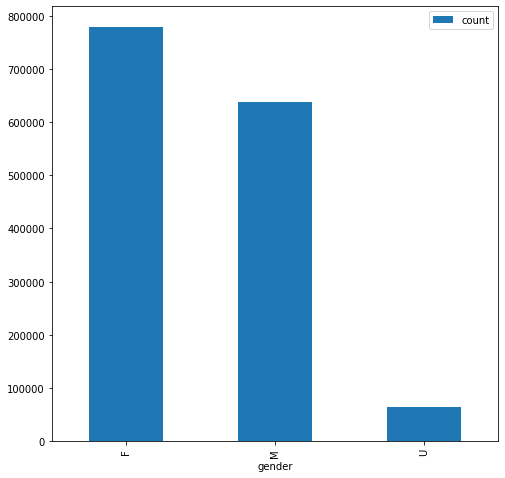

In [79]:
figures, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
county_voters_registration_df.groupby(['gender'])['voter_id'].agg(['count']).plot(kind='bar', ax=axes)

In [80]:
last_name_freq = county_voters_registration_df.groupby(['last_name'])['voter_id'].agg(['count']).reset_index()

In [84]:
top_10_freq_last_name = last_name_freq.sort_values(by='count', ascending=False)[:10]

In [87]:
sns.catplot(x=top_10_freq_last_name.last_name, y=top_10_freq_last_name.count)

TypeError: float() argument must be a string or a number, not 'method'